# Advanced functionality


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact

from reflectorch import *
from reflectorch.extensions.jupyter import JPlotLoss

torch.manual_seed(0); # set seed for reproducibility

## Model with absorption

The default box model parameterization of the SLD profile presented in the previous sections takes into account only the real part of the SLD profile but neglects the imaginary part of the SLD which is related to the absorption of the scattering medium. While this is a reasonable approximation in many use cases, in `reflectorch` we are able to alter the parameterization of the SLD profile as to also incorporate the constant imaginary SLD value of each layer.

We can initialize a reflectorch model with absorption by making the following changes to the YAML configuration file:

 1. Firstly, we set the `model_name` argument of the prior sampler to `model_with_absorption` instead of `standard_model`. In addition, the parameter range and bound width range of the imaginary layer SLDs (`islds`) must be specified.  

```{code-block} yaml
:emphasize-lines: 9,14,15

dset:
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
        thicknesses: [0., 300.]
        roughnesses: [0., 20.]
        slds: [0., 50.]
        islds: [0., 5.]
      bound_width_ranges:
        thicknesses: [ 1.0e-2, 300.]
        roughnesses: [ 1.0e-2, 20.]
        slds: [ 1.0e-2, 10.]
        islds: [ 1.0e-2, 5.]
      model_name: model_with_absorption
      max_num_layers: 2
      constrained_roughness: true
      max_thickness_share: 0.5
      logdist: false
```

2. For the 2-layer box model parameterization of the SLD profile without absorption, the neural network had to predict 8 values (2 thicknesses, 3 roughnesses, 3 real layer SLDs). When absorption is considered, we have 3 additional output values (the imaginary layer SLDs), summing up to a total of 11. The computation for a higher number of layers is analogous. Thus the neural network architecture must also reflect theses changes in the input and output dimensionalities: in this example the `dim_out` argument is set to 11.

```{code-block} yaml
:emphasize-lines: 12

model:
  encoder:
    cls: PriorInformedNetworkConvEmb
    pretrained_name: null
    kwargs:
      in_channels: 1
      hidden_channels: [32, 64, 128, 256, 512]
      dim_embedding: 128
      dim_avpool: 1
      embedding_net_activation: 'gelu'
      use_batch_norm: true
      dim_out: 11
      layer_width: 512
      num_blocks: 6
      repeats_per_block: 2
      mlp_activation: 'gelu'
      dropout_rate: 0.0 
      pretrained_embedding_net: null
```

We initialize a model with absorption from a suitable configuration file.

In [2]:
trainer = get_trainer_by_name(config_name='c_absorption', load_weights=False)

Model c_absorption loaded. Number of parameters: 3.84 M


In [3]:
batch_size = 64
simulated_data = trainer.loader.get_batch(batch_size)

n_layers = simulated_data['params'].max_layer_num
n_params = simulated_data['params'].num_params

print(f'Number of layers: {n_layers},  Number of film parameters: {n_params}')
print(simulated_data['params'].slds.dtype)

Number of layers: 2,  Number of film parameters: 11
torch.complex128


We observe that the `slds` tensor is of complex type now.

The absorption leads to the rounding of the total reflection edge and the smoothing-off of oscillations of the reflectivity curve.

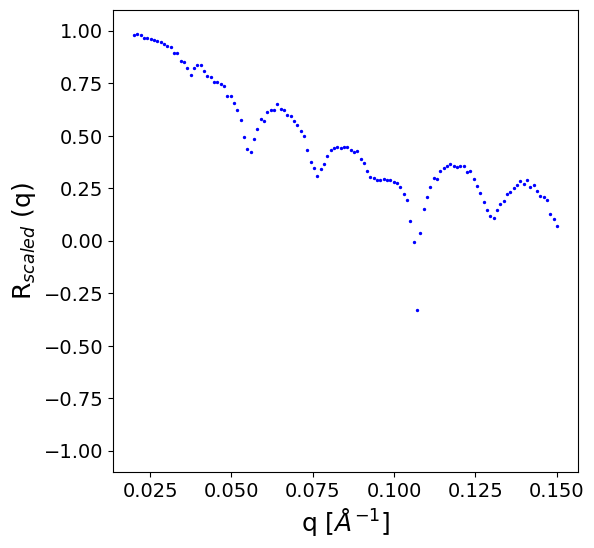

In [4]:
q = to_np(simulated_data['q_values'])[0]
scaled_noisy_curves = simulated_data['scaled_noisy_curves']

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=18)
ax.set_ylabel('R$_{scaled}$ (q)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

i = 0
ax.scatter(q, to_np(scaled_noisy_curves[i]), c='blue', s=2.0);

The imaginary part of the SLD can be constrained during sampling as to not exceed a predefined fraction of the real part of the SLD (*future version*).

## Alternative parameterizations of the SLD profile

In this section we describe alternative parameterizations of the SLD profile implementated in `reflectorch` (i.e. other than the standard box model parameterization)

### Periodically repeating multilayer

This SLD parameterization addresses the following commonly encountered scenario for thin films. On top of a silicon/silicon oxide substrate we consider a thin film composed of repeating identical monolayers (grey curve in the figure), each monolayer consisting of two boxes with distinct SLDs. A sigmoid envelope modulating the SLD profile of the monolayers defines the film thickness and the roughness at the top interface (green curve in the figure). A second sigmoid envelope can be used to modulate the amplitude of the monolayer SLDs as a function of the displacement from the position
of the first sigmoid (red curve in the figure). These two sigmoids allow one to model a thin film that is coherently ordered up to a certain coherent thickness and gets incoherently ordered or amorphous toward the top of the film. In addition, a layer between the substrate and the multilayer (i.e. ”phase layer”) is introduced to account for the interface structure, which does not necessarily have to be identical to the multilayer period.

```{figure} sketch_multilayer_0.png
:scale: 50
:align: center
:name: figure_multilayer
SLD parameterization of a periodically repeating multilayer
```

This parameterization is described by 17 film parameters, their physical description together with their corresponding alias in the YAML configuration file being shown in the following table:

| **Parameter description** | **Parameter alias in the configuration file** |
|---------------|---------------------|
| monolayer thickness (i.e. two boxes stacked together) | d_block |
| relative roughness of the monolayer interfaces (wrt. the monolayer thickness) | s_block_rel |
| SLD of the first box in the monolayer | r_block |
| SLD difference between the second and the first box in the monolayer | dr |
| fraction of the monolayer thickness belonging to the first box | d_block1_rel |
| roughness of the silicon substrate | s_si |
| SLD of the silicon substrate | r_si |
| thickness of the silicon oxide layer | d_sio2 |
| roughness of the silicon oxide layer | s_sio2 |
| SLD of the silicon oxide layer | r_sio2 |
| SLD of the phase layer | r3 |
| relative thickness of the phase layer (wrt. the monolayer thickness) | d3_rel |
| relative roughness of the phase layer (wrt. the monolayer thickness) | s3_rel |
| relative position of the first sigmoid (i.e. total film thickness) | d_full_rel |
| relative width of the first sigmoid | rel_sigmas |
| relative position of the second sigmoid (coherently ordered film thickness) | dr_sigmoid_rel_pos |
| relative width of the second sigmoid | dr_sigmoid_rel_width |

We can initialize a reflectorch model which uses this type of SLD parameterization by making the following changes to the YAML configuration file:

 1. Firstly, we set the `model_name` argument of the prior sampler to `model3` (--to be renamed--) instead of `standard_model`, and the `max_num_layers` argument to a high value (such as 30). In addition,the parameter ranges and bound width ranges for the 17 multilayer parameters must be specified (the above table shows the correspondance between the physical parameters and the corresponding YAML subkeys). 

```{code-block} yaml
:emphasize-lines: 41, 42

dset:
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
          d_full_rel: [0, 25]
          rel_sigmas: [0, 5]
          dr_sigmoid_rel_pos: [-10, 10]
          dr_sigmoid_rel_width: [0, 20]
          d_block1_rel: [0.01, 0.99]
          d_block: [10, 20]
          s_block_rel: [0., 0.3]
          r_block: [0., 20.] 
          dr: [-10., 10.]
          d3_rel: [0, 1] 
          s3_rel: [0, 1] 
          r3: [0., 25] 
          d_sio2: [0, 10] 
          s_sio2: [0, 10] 
          s_si: [0., 10] 
          r_sio2: [17., 19.]
          r_si: [19., 21.]
      bound_width_ranges:
          d_full_rel: [0.1, 25]
          rel_sigmas: [0.1, 5]
          dr_sigmoid_rel_pos: [0.1, 20]
          dr_sigmoid_rel_width: [0.1, 20]
          d_block1_rel: [0.01, 1.0]
          d_block: [0.1, 10.]
          s_block_rel: [0.1, 0.3]
          r_block: [0.1, 5.]
          dr: [0.1, 5.]
          d3_rel: [0.01, 1]
          s3_rel: [0.01, 1]
          r3: [0.01, 25]
          d_sio2: [0.01, 10]
          s_sio2: [0.01, 10]
          s_si: [0.01, 10]
          r_sio2: [0.01, 2]
          r_si: [0.01, 2]
      model_name: model3
      max_num_layers: 30
      logdist: false
```

2. The neural network architecture must be set up such that the `dim_out` argument (i.e. the output dimension) is set to the number of predicted parameters which in this case is 17.

```{code-block} yaml
:emphasize-lines: 12

model:
  encoder:
    cls: PriorInformedNetworkConvEmb
    pretrained_name: null
    kwargs:
      in_channels: 1
      hidden_channels: [32, 64, 128, 256, 512]
      dim_embedding: 128
      dim_avpool: 1
      embedding_net_activation: 'gelu'
      use_batch_norm: true
      dim_out: 17
      layer_width: 512
      num_blocks: 6
      repeats_per_block: 2
      mlp_activation: 'gelu'
      dropout_rate: 0.0 
      pretrained_embedding_net: null
```

<!-- ```{figure} fig_reflectometry_embedding_networks.png
:scale: 25 %
:align: center
:name: embedding_networks
Embedding Networks
``` -->

We initialize a model with absorption from a suitable configuration file. Here we use an extended q range, up to 0.5 Å$^{-1}$.

In [5]:
trainer = get_trainer_by_name(config_name='c_repeating_multilayer', load_weights=False)

Model c_repeating_multilayer loaded. Number of parameters: 3.85 M


In [6]:
simulated_data = trainer.loader.get_batch(batch_size=64)

n_layers = simulated_data['params'].max_layer_num
n_params = simulated_data['params'].num_params

print(f'Number of layers: {n_layers},  Number of film parameters: {n_params}')

Number of layers: 30,  Number of film parameters: 17


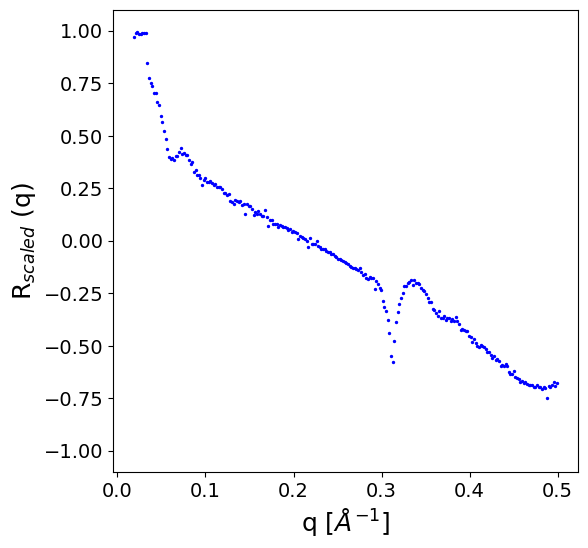

In [7]:
q = to_np(simulated_data['q_values'])[0]
scaled_noisy_curves = simulated_data['scaled_noisy_curves']

i = 1

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=18)
ax.set_ylabel('R$_{scaled}$ (q)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
    
ax.scatter(q, scaled_noisy_curves[i].cpu().numpy(), c='blue', s=2.0);

## Using different embedding networks

Embedding networks have the role of processing the reflectivity curves, producing a latent representation which is fed together with the prior bounds to the main fully-connected (MLP) network in order to obtain the predictions. The default embedding network is the 1D CNN which works on reflectivity curves with fixed discretization (fixed q range and number of points in the curves). The arguments of the 1D CNN embedding network have been already explained in the previous section.

```{figure} fig_reflectometry_embedding_networks.png
:scale: 25
:align: center
:name: figure_embedding_networks
Embedding networks
```

Alternatively, we can use an embedding network inspired by the Fourier Neural Operator (FNO) architecture. In this scenario the reflectivity curves together with their respective q-values are input to the embedding network. It allows us to train the model on reflectivity curves with variable discretizations (variable q ranges and numbers of points in the curves). Notably, due to the limitations of the fast fourier transform, the q points should still be equidistant. 

We can initialize a reflectorch model which uses the FNO-based embedding network by making the following changes to the YAML configuration file:

 1. Firstly, the `q_generator` has to be changed to `VariableQ` instead of `ConstantQ`. Its arguments are:
 - `q_min_range` - the range for sampling the minimum q value of the curves, *q_min*
 - `q_max_range` - the range for sampling the maximum q value of the curves, *q_max*
 - `n_q_range` - the range for the number of points in the curves (equidistantly sampled between *q_min* and *q_max*, the number of points varies between batches but is constant within a batch)

```{code-block} yaml
:emphasize-lines: 3, 5, 6, 7
dset:     
  q_generator:
    cls: VariableQ
    kwargs:
      q_min_range: [0.01, 0.03]
      q_max_range: [0.15, 0.3]
      n_q_range: [64, 256]
```

 2. The network architecture is changed to be an instance of the `PriorInformedNetworkFnoEmb` class, which has the following keyword arguments:

- `in_channels` - the number of input channels to the FNO-based embedding network  (should be 2: (R(q), q))
- `dim_embedding` - the dimension of the embedding produced by the FNO
- `width_fno` - the number of channels in the FNO blocks
- `n_fno_blocks`- the number of FNO blocks
- `modes` - the number of Fourier modes that are utilized
- `embedding_net_activation` - the type of activation function in the embedding network
- `use_batch_norm` - whether to use batch normalization (only in the MLP)

The other keyword arguments are the same as for the `PriorInformedNetworkConvEmb` class.


```{code-block} yaml
:emphasize-lines: 3, 6, 8, 9, 10

model:
  encoder:
    cls: PriorInformedNetworkFnoEmb
    pretrained_name: null
    kwargs:
      in_channels: 2
      dim_embedding: 256
      width_fno: 128
      n_fno_blocks : 6
      modes: 32
      embedding_net_activation: 'gelu'
      use_batch_norm: True
      dim_out: 8
      layer_width: 512
      num_blocks: 6
      repeats_per_block: 2
      mlp_activation: 'gelu'
      dropout_rate: 0.0 
```

3. The `train_with_q_input` subkey of the `training` key must be set to `True`. Enabling gradient clipping (`clip_grad_norm_max`) is also recommended.

```{code-block} yaml
:emphasize-lines: 6, 7

training:
  num_iterations: 10000
  batch_size: 1024
  lr: 1.0e-4
  grad_accumulation_steps: 1
  clip_grad_norm_max: 1.0
  train_with_q_input: True
```

We initialize a model having a FNO-based embedding network from a suitable configuration file:

In [8]:
trainer = get_trainer_by_name(config_name='c_fno', load_weights=False)

Model c_fno loaded. Number of parameters: 6.59 M


In [9]:
trainer.model

PriorInformedNetworkFnoEmb(
  (embedding_net): FnoEncoder(
    (activation): GELU(approximate='none')
    (fc0): Linear(in_features=2, out_features=128, bias=True)
    (spectral_convs): ModuleList(
      (0-5): 6 x SpectralConv1d()
    )
    (w_convs): ModuleList(
      (0-5): 6 x Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    )
    (fc_out): Linear(in_features=128, out_features=256, bias=True)
  )
  (mlp): ResidualMLP(
    (first_layer): Linear(in_features=272, out_features=512, bias=True)
    (blocks): ModuleList(
      (0-5): 6 x ResidualBlock(
        (activation): GELU(approximate='none')
        (batch_norm_layers): ModuleList(
          (0-1): 2 x BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (linear_layers): ModuleList(
          (0-1): 2 x Linear(in_features=512, out_features=512, bias=True)
        )
      )
    )
    (last_layer): Linear(in_features=512, out_features=8, bias=True)
  )
)

We briefly inspect the q values of the reflectivity curves:

In [10]:
batch_size = 64
simulated_data = trainer.loader.get_batch(batch_size)
q = simulated_data["q_values"]

print(q.shape) # (batch_size, num_points), num_points constant within one batch and variable between batches
print(q[0, :]) #q values for first curve in the batch
print(q[1, :]) #q values for second curve in the batch

torch.Size([64, 68])
tensor([0.0222, 0.0253, 0.0284, 0.0315, 0.0346, 0.0377, 0.0408, 0.0439, 0.0470,
        0.0500, 0.0531, 0.0562, 0.0593, 0.0624, 0.0655, 0.0686, 0.0717, 0.0748,
        0.0779, 0.0809, 0.0840, 0.0871, 0.0902, 0.0933, 0.0964, 0.0995, 0.1026,
        0.1057, 0.1088, 0.1118, 0.1149, 0.1180, 0.1211, 0.1242, 0.1273, 0.1304,
        0.1335, 0.1366, 0.1397, 0.1427, 0.1458, 0.1489, 0.1520, 0.1551, 0.1582,
        0.1613, 0.1644, 0.1675, 0.1706, 0.1736, 0.1767, 0.1798, 0.1829, 0.1860,
        0.1891, 0.1922, 0.1953, 0.1984, 0.2015, 0.2046, 0.2076, 0.2107, 0.2138,
        0.2169, 0.2200, 0.2231, 0.2262, 0.2293], device='cuda:0',
       dtype=torch.float64)
tensor([0.0265, 0.0292, 0.0318, 0.0345, 0.0371, 0.0398, 0.0424, 0.0451, 0.0477,
        0.0504, 0.0530, 0.0557, 0.0584, 0.0610, 0.0637, 0.0663, 0.0690, 0.0716,
        0.0743, 0.0769, 0.0796, 0.0822, 0.0849, 0.0875, 0.0902, 0.0928, 0.0955,
        0.0981, 0.1008, 0.1034, 0.1061, 0.1088, 0.1114, 0.1141, 0.1167, 0.1194,
     

At inference time, the input to the network also includes the q values:

```python
scaled_input = torch.cat([scaled_noisy_curves, scaled_bounds], dim=-1).float()
with torch.no_grad():
    trainer.model.eval()
    scaled_predicted_params = trainer.model(scaled_input, q) #the q values are the second argument of the network
```